# Introduction
---
Using the [Pushshift API](https://github.com/pushshift/api), we will be scraping posts and comments from two subreddits from Reddit.com - [/r/csMajors](https://www.reddit.com/r/csmajors) and [/r/codingbootcamp](https://www.reddit.com/r/codingbootcamp/).

Following which, we will train a classifier that can distinguish which of the two subreddits a post belongs to.

## Contents

- [Problem Statement](#problem-statement)
- [Data Collection](#data-collection)
- [Data Cleaning & EDA](#data-cleaning-and-exploratory-data-analysis)
- [Modeling](#modelling)
- [Model Evaluation](#model-evaluation-and-tuning)
- [Conclusion and Recommendations](#conclusion--recommendations)

## Problem Statement
We are blah blah blah and we want to lah lah lah.

In [1]:
# import required libraries
import requests
import pandas as pd
import numpy as np
import datetime as dt
from nltk import WordNetLemmatizer
from string import punctuation
import re
import time
import os
import joblib
from wordcloud import WordCloud

import seaborn as sns
sns.set(style='whitegrid')
import matplotlib.pyplot as plt

from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS, CountVectorizer, TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB, ComplementNB
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import LinearSVC
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay, RocCurveDisplay

import warnings
warnings.filterwarnings("ignore")

## Data Collection
---
The first step in our journey is to collect submissions from the subreddits that we are interested in. With the use of Pushshift API, we can easily define a few functions to help us automate the collection process.

We will attempt to collect 5,000 posts from each of the subreddits for our analysis.

In [2]:
def call_pushshift(subreddit, size, before):
    '''
    Sends a GET request to Pushshift API and checks API response

    Parameters
    ----------
    subreddit : str
        Subreddit to scrape
    size : int
        Number of posts to scrape. Pushshift API caps at 250 posts per response 
    before: Epoch value or int + "s,m,h,d" (i.e. 30d for 30 days)
        Returns results before this date

    Returns
    -------
    DataFrame
        A dataframe containing date, title, text and subreddit name of all scraped posts.
    '''
    # set API parameters
    url = 'https://api.pushshift.io/reddit/search/submission'
    # retrieve specified fields only to reduce file size
    fields = ['created_utc','title',
                'selftext','subreddit']
    params = {
        'subreddit': subreddit,
        'sort': 'desc',
        'sort_type': 'created_utc',
        'size': size,
        'is_video': 'false',
        'metadata': 'true',
        'fields': fields,
        'stickied': 'false',
        'before': before
    }
    # check that API response is received successfully
    try:
        response = requests.get(url, params).json()
        if response['metadata']['timed_out'] == False:
            print("Success")
            print()
            return pd.DataFrame(response['data'])
        elif response['metadata']['timed_out'] == True:
            print(f"Error, timeout after {response['metadata']['execution_time_milliseconds']}")
            return pd.DataFrame()
    except Exception as e:
        print(f"Error occurred: {e}")

In [3]:
def retrieve_data(subreddits, posts, before='0d'):
    '''
    Scrapes specified number of posts from subreddit threads.

    Parameters
    ----------
    subreddits : list[str]
        Lists of subreddits to scrape
    posts : int
        Expected number of posts to scrape in total
    before: Epoch value or int + "s,m,h,d" (i.e. 30d for 30 days)
        Returns results before this date, default '0d'

    Returns
    -------
    DataFrame
        A dataframe containing date, title, text and subreddit name of all scraped posts from all subreddits.
    '''
    #calculate the number of attempts to retrieve required posts
    limit = 250 # max limit of results from pushshift api
    counts = int(posts / limit)
    sizes = [limit for i in range(counts)]
    if posts % limit:
        sizes.append(posts % limit)

    # create list of dataframes for merging
    subreddit_dfs = []

    for subreddit in subreddits:
        print(f"Retrieving {posts} from '{subreddit}', {len(sizes)} attempts required:")
        dfs = []

        for i, size in enumerate(sizes):
            print(f"Attempt {i+1}/{len(sizes)}, retrieving {size} posts from '{subreddit}'")
            # set param size to retrieve for this call
            # params['size'] = size
            # retrieve posts
            ps_df = call_pushshift(subreddit, size, before)
            # set param before to retrieve for next call
            before = ps_df['created_utc'].iloc[-1]
            # append df for merger
            dfs.append(ps_df)
            # insert random interval between scraping
            time.sleep(np.random.uniform(1,3))

        # merging retrieved dataframes
        df = pd.concat(dfs, ignore_index=True)
        subreddit_dfs.append(df)
    
    merged_df = pd.concat(subreddit_dfs, ignore_index=True)

    print("Completed")
    print(f"Total {len(merged_df)} records retrieved from {subreddits}")
    return merged_df

In [4]:
# define subreddits to extract
subreddits = ['csmajors', 'codingbootcamp']

# df = retrieve_data(subreddits, 5000)

# check for data folder to store backup csv
if not os.path.isdir('../data'):
    os.mkdir('../data')
    
# store backup copy of df
# df.to_csv(f'../data/records_{"_".join(subreddits)}.csv', index=False)

In [5]:
# read from backup if no need for updated posts
df = pd.read_csv(f'../data/records_{subreddits[0]}_{subreddits[1]}.csv')

## Data Cleaning and Exploratory Data Analysis
---
Now that the data has been collected, we will identify if any cleaning is required, followed by some EDA to better understand the dataset.

In [6]:
# check for number of retrieved posts by subreddit
df['subreddit'].value_counts()

csMajors          4992
codingbootcamp    4990
Name: subreddit, dtype: int64

In [7]:
# convert subreddit tags to lower case for easier handling
df['subreddit'] = df['subreddit'].str.lower()

In [8]:
# convert created_utc from Epoch value to datetime format
df['created_utc'] = df['created_utc'].apply(dt.datetime.utcfromtimestamp)

Due to the nature of online forums such as Reddit, there may be tendencies for "reposting" of the same content, so we will drop any duplicates in our data and keep the oldest post.

In [9]:
# check and drop any duplicated posts, e.g. reposts by the same author or bot
df.drop_duplicates(subset=['selftext', 'title', 'subreddit'], keep='last', inplace=True)

In [10]:
# check for missing values
df.isnull().sum()

created_utc       0
selftext       1492
subreddit         0
title             0
dtype: int64

In [11]:
# check samples
df.tail(20)

,created_utc,selftext,subreddit,title
9962,2022-10-15 00:20:02,"\n\nHello all!\n\nGraduating 2023, so 0 YOE\n...",csmajors,Should I accept an offer out of safety even if...
9963,2022-10-15 00:19:32,For SWE Intern. Would have to renege LinkedIn\...,csmajors,Two Sigma vs LinkedIn
9964,2022-10-15 00:10:17,The reason I said this is kind of a desperatio...,csmajors,Desperation Post (Kinda): Options for Employment
9965,2022-10-15 00:08:49,Considering that you hope for a great return n...,csmajors,Which one would you choose for an internship?
9966,2022-10-14 23:58:08,For those who did an Ericsson Engineer intervi...,csmajors,Ericsson Engineer Intern Interview?
9967,2022-10-14 23:57:47,"Hey, \nSo it seems like a bunch of us were tol...",csmajors,Pinterest SWE Intern
9968,2022-10-14 23:56:59,[removed],csmajors,Ericsson Engineer Intern Interview?
9969,2022-10-14 23:48:36,Has anyone heard back from crowdstrike after t...,csmajors,Crowdstrike phone?
9970,2022-10-14 23:47:28,"Hi, \n\nI was invited to participate in the JP...",csmajors,JPMorgan CFG Hackathon after rejection?
9971,2022-10-14 23:45:42,has anyone done the blackstone first round tec...,csmajors,blackstone interview


When checking for missing values, there are a large number of missing values for 'selftext'. Reddit allows users to create posts with just a title (up to 300 characters) and no text, so the high number of missing values in selftext may not be surprising. 

<img src='../images/reddit_post.png' width=60% alt='creating new reddit post'>

Source: [Reddit.com](https://www.reddit.com/submit)

Instead, we will merge the two 'selftext' and 'title' columns into a `text` column for our analysis. However, before we do that, we observe that there are posts with selftext as [removed].

In [12]:
# check for number of removed or deleted posts
df[df['selftext'].isin(['[removed]', '[deleted]'])].groupby("subreddit").created_utc.count()

subreddit
codingbootcamp    320
csmajors          562
Name: created_utc, dtype: int64

We see that there are a large number of [removed] and [deleted] posts within our dataset. Due to content moderation on Reddit, posts that do not comply with the subreddit regulations are often removed by moderators or bots. This likely also implies that such posts would not be helpful in our classification, so we will remove them from our data.

<img src='../images/removed_post.png' width=60% alt='removed reddit post'>

Source: [Reddit.com](https://www.reddit.com/r/singapore/comments/z2p0ro/list_of_government_apps/)

In [13]:
# drop removed and deleted posts from df
df.drop(index=df[df['selftext'].isin(['[removed]', '[deleted]'])].index, inplace=True)

In [14]:
# merge title and selftext for subsequent analysis
df['text'] = df['title'].str.cat(df['selftext'], sep=' ', na_rep=' ')

Before we can use the `text` data to create our classification model, we will need to process and clean the text. Based on the samples extracted, we will need to perform the following:

> 1. Convert text to lower case
> 1. Remove punctuation
> 1. Removing urls and tags in brackets [ ] or parenthesis ( )
> 1. Lemmatizing words (grouping different inflected forms of a word)
> 1. Removing common stopwords

Lemmatizing is the process of grouping inflected or variant forms of the same word, so that they can be analysed as a single item. This is often more natural as compared to stemming, which can return non-words, as can be seen from the image below. Since we are interested in finding key words from our model output, lemmatizing would be the more suitable option.

![stem vs lemmatization](../images/stemvslemma.png)

[Source: Stemming vs Lemmatization](https://www.baeldung.com/cs/stemming-vs-lemmatization)

Stopwords are commonly used English words that are often uninformative and not useful in our analysis, such as 'and', 'it' or 'the'. While the impact of stopwords would likely be reduced by the use of a TF-IDF Vectorizer, dropping these words can reduce the complexity of our model and improve the speed.

We will also utilise a WordCloud to check for any commonly occurring words to add into our stopwords. Words that appear too frequently in both subreddits may likewise not be very helpful in our classification.

In [15]:
def plot_wordcloud(text):
    '''
    Returns a wordcloud with top 200 words from a list of strings

    Parameters
    ----------
    text : list[str]
        List of string text to process and display in wordcloud
    '''
    wc_text = " ".join(text).lower()
    plt.figure(figsize=(8, 6))
    wordcloud = WordCloud(
        background_color="white",
        max_words=200,
        width=1080,
        height=720,
        colormap="turbo",
        include_numbers=True,
    ).generate(wc_text)
    plt.imshow(wordcloud)
    plt.axis("off");

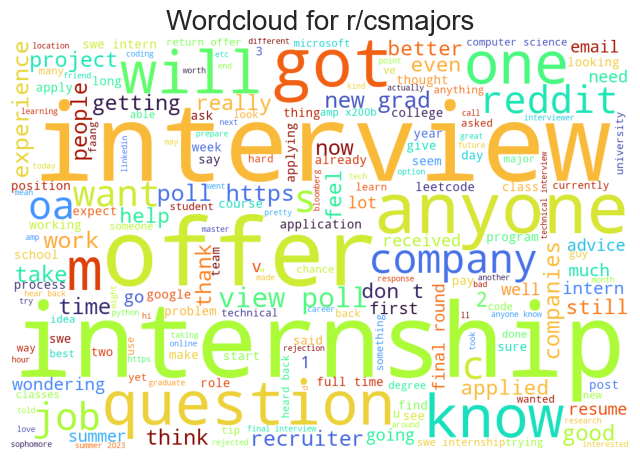

In [16]:
plot_wordcloud(df[df['subreddit'] == subreddits[0]]['text'])
plt.title(f"Wordcloud for r/{subreddits[0]}", fontsize=20);

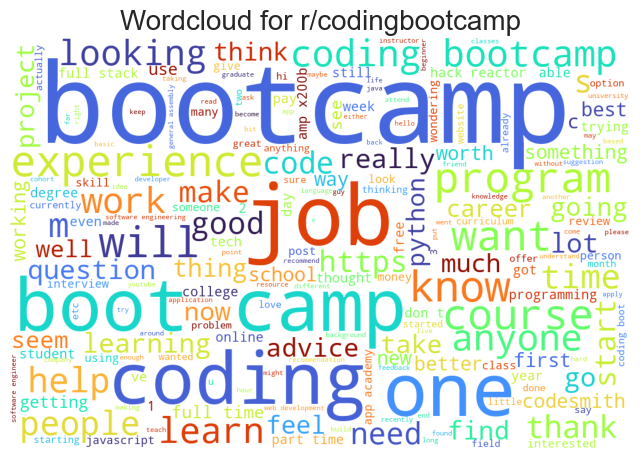

In [17]:
plot_wordcloud(df[df['subreddit'] == subreddits[1]]['text'])
plt.title(f"Wordcloud for r/{subreddits[1]}", fontsize=20);

Looking through the wordcloud, we see that there are some words that may not be very useful in classification and can likely be dropped, such as `view` and `poll`, which would be common with "poll" type of posts. Such words that are not present in our `sklearn ENGLISH_STOP_WORDS` can be added to better refine our model.

Words like `https` would suggest that there are html links to be removed using RegEx.

In [18]:
# create function for cleaning and lemmatizing text
def clean_text(text):
    '''
    Prepare text for modelling
    
    Parameters
    ----------
    text : str
        String text to clean, lemmatize and drop stopwords
    '''
    wn = WordNetLemmatizer()

    # add extra stopwords
    extra_stopwords = [
        "im", "ve", "ive", "hello", "view",
        "poll", "dont", "know", "ampx200b",
        "wa", "ha", "just", "like",
        "got", "did", "bootcamp",
        "bootcamps", "boot", "camp",
        "feel", "free", "want", "thanks",
    ]
    custom_stopwords = ENGLISH_STOP_WORDS.union(extra_stopwords)

    # convert to lower case, remove URLs and tags in [] or ()
    text = re.sub(r"/\[.+\]|\(.+\)|https?:\/\/.+\b", "", text.lower())
    # remove punctuation
    text_nopunct = "".join([char for char in text if char not in punctuation])
    # tokenize
    tokens = re.split(r"\W+", text_nopunct)
    # lemmatize
    tokens_lm = [wn.lemmatize(token) for token in tokens if len(token)]
    # drop stopwords
    text_cleaned = " ".join(
        [token for token in tokens_lm if token not in custom_stopwords]
    )
    return text_cleaned if len(text_cleaned) else None


In [19]:
# apply function to text
df['text_cleaned'] = df['text'].apply(clean_text)

In [20]:
# drop rows that have no useful words after cleaning
df.dropna(subset='text_cleaned', inplace=True)

In [21]:
# create new column for the length of cleaned text
df['text_length'] = df['text_cleaned'].apply(len)

Having cleaned the data of any duplicate, removed and deleted posts, our remaining dataset has a rather even 50.38% : 49.62% split between r/codingbootcamp and r/csMajors.

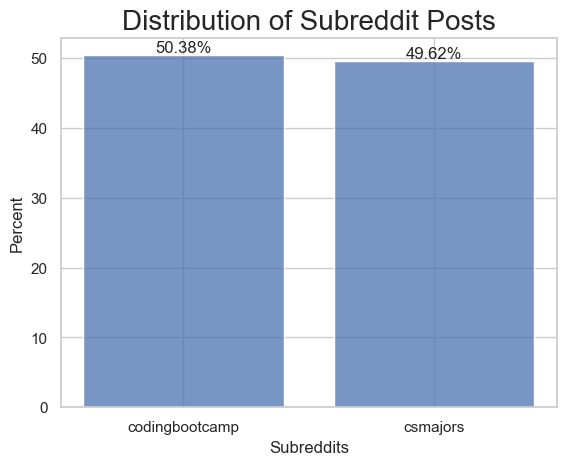

In [22]:
# check distribution of dataset
plt.figure()
plot = sns.histplot(df['subreddit'], discrete=True, shrink=0.8, stat='percent')
plt.title("Distribution of Subreddit Posts", fontsize=20)
plt.xlabel("Subreddits");

# show data labels for easier visualisation
for i, bar in enumerate(plot.patches):
    h = bar.get_height() # get value
    plot.text(
        i, # bar index (x coordinate of text)
        h + 1, # y coordinate of text
        f'{h:.2f}%',  # label format
        ha='center',
        va='center',
    )

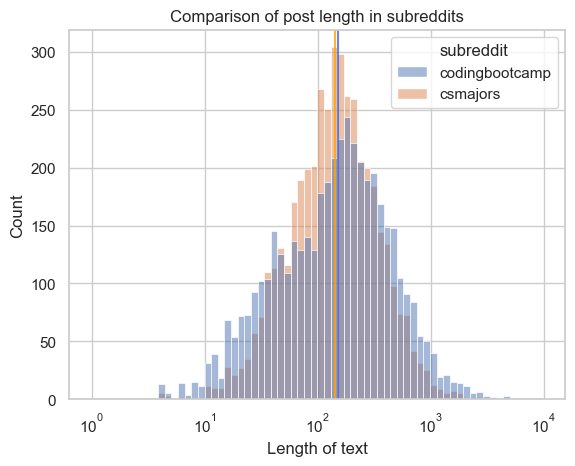

In [23]:
# check length of posts
sns.histplot(data=df, x="text_length", hue="subreddit", log_scale=True)
plt.axvline(
    df.loc[df["subreddit"] == subreddits[0], "text_length"].median(),
    color="orange",
    alpha=0.8,
)
plt.axvline(
    df.loc[df["subreddit"] == subreddits[1], "text_length"].median(),
    color="royalblue",
    alpha=0.8,
)
plt.xlabel("Length of text")
plt.title("Comparison of post length in subreddits");

In [24]:
df.text_length.describe()

count    8892.000000
mean      226.647323
std       323.063599
min         1.000000
25%        67.000000
50%       145.000000
75%       274.000000
max      9787.000000
Name: text_length, dtype: float64

After cleaning the text, we see that r/codingbootcamp generally has a wider range of posts length, with some very short or long posts. However, the median for both subreddits are around the same.

The longest post has close to 10,000 characters, while the shortest post has just 1 character. Posts that are too short may not contain many useful key words and could be less helpful in our classification.

In [25]:
df[df['text_length'] < 10]['subreddit'].value_counts()

codingbootcamp    65
csmajors          15
Name: subreddit, dtype: int64

In [26]:
df.loc[df['text_length'] < 10, 'text_cleaned'].tail(10)

6200      job job
6326        happy
6527      walmart
6779         pain
6948        offer
7111          bop
7815    sigh sigh
8128     choose c
9012         join
9745        chegg
Name: text_cleaned, dtype: object

Of the terms from the sample posts with <10 characters, these posts may not be very helpful in training our classification model, so we will drop them.

In [27]:
df.drop(index=df[df['text_length'] < 10].index, inplace=True)

In [28]:
df['subreddit'].value_counts()

codingbootcamp    4415
csmajors          4397
Name: subreddit, dtype: int64

After dropping the shorter posts, we have around 4,400 posts remaining for both subreddits.

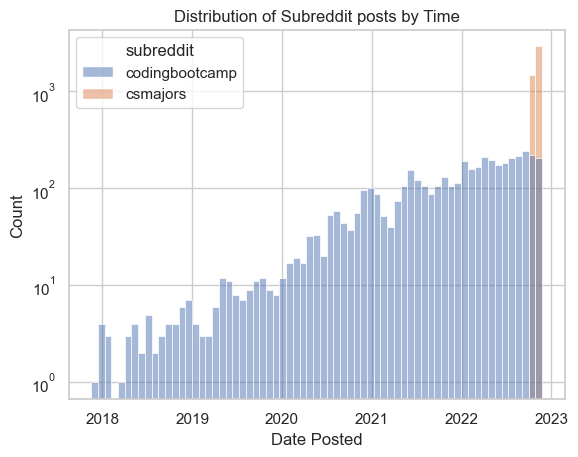

In [29]:
# check distribution of posts by time
sns.histplot(data=df, x='created_utc', hue='subreddit', stat='count', log_scale=(0,10))
plt.title("Distribution of Subreddit posts by Time")
plt.xlabel("Date Posted");

We see that the posts from r/csmajors are more recent, as opposed to posts from r/codingbootcamp which span from 2018 to 2022. Since we are scraping posts by recency of posting, it suggests that the r/codingbootcamp subreddit is significantly less active as compared to r/csmajors, although this should not impact our model significantly.

## Preprocessing
---
In order for our machine learning model to process the text, it will need to be converted into numerical features. We will be utilising the `CountVectorizer` and `TfidfVectorizer` from the sklearn library to convert our cleaned text into feature vectors using the bag of words model. This is essentially a count of how often each unique word within our dataset appears across all the posts.

- Count Vectorizer takes each word from every post & creates a feature from it by counting how often that word occurs in the entire dataset.
- TF-IDF Vectorizer does the same, but instead of returning a count, returns the frequency as a percentage scaled by how often it appears across all documents.

First using the CountVectorizer, we will identify the top 20 words from each subreddit. We will compare between the unigram, bigram and trigrams to see if there are any interesting features.

In [30]:
# create function that plots top 20 n-grams for both subreddits
def plot_top20(n_range=(1,1), columns=subreddits):
    vect = CountVectorizer(ngram_range=n_range)

    # create subplots
    fig, ax = plt.subplots(nrows=1, ncols=len(columns), figsize=(16,8))
    ax = ax.ravel()
        
    # vectorize and plot top 20 words
    for i, col in enumerate(columns):
        plot_matrix = vect.fit_transform(df[df['subreddit'] == col]['text_cleaned'])
        
        df_plot = pd.DataFrame.sparse.from_spmatrix(
            data = plot_matrix,
            columns = vect.get_feature_names_out()
            )
        counts_count = df_plot.sum(axis=0)

        ax[i].barh(
            counts_count.sort_values(ascending=True).tail(20).index, 
            width = counts_count.sort_values(ascending=True).tail(20)
            )
            
        ax[i].set_title(f"Top 20 features in r/{col}", fontsize=20)
        ax[i].tick_params(labelsize=18)

    fig.suptitle(f"Count Vectorized [N-Gram({n_range})]", fontsize=23)
    plt.tight_layout();

### Unigram

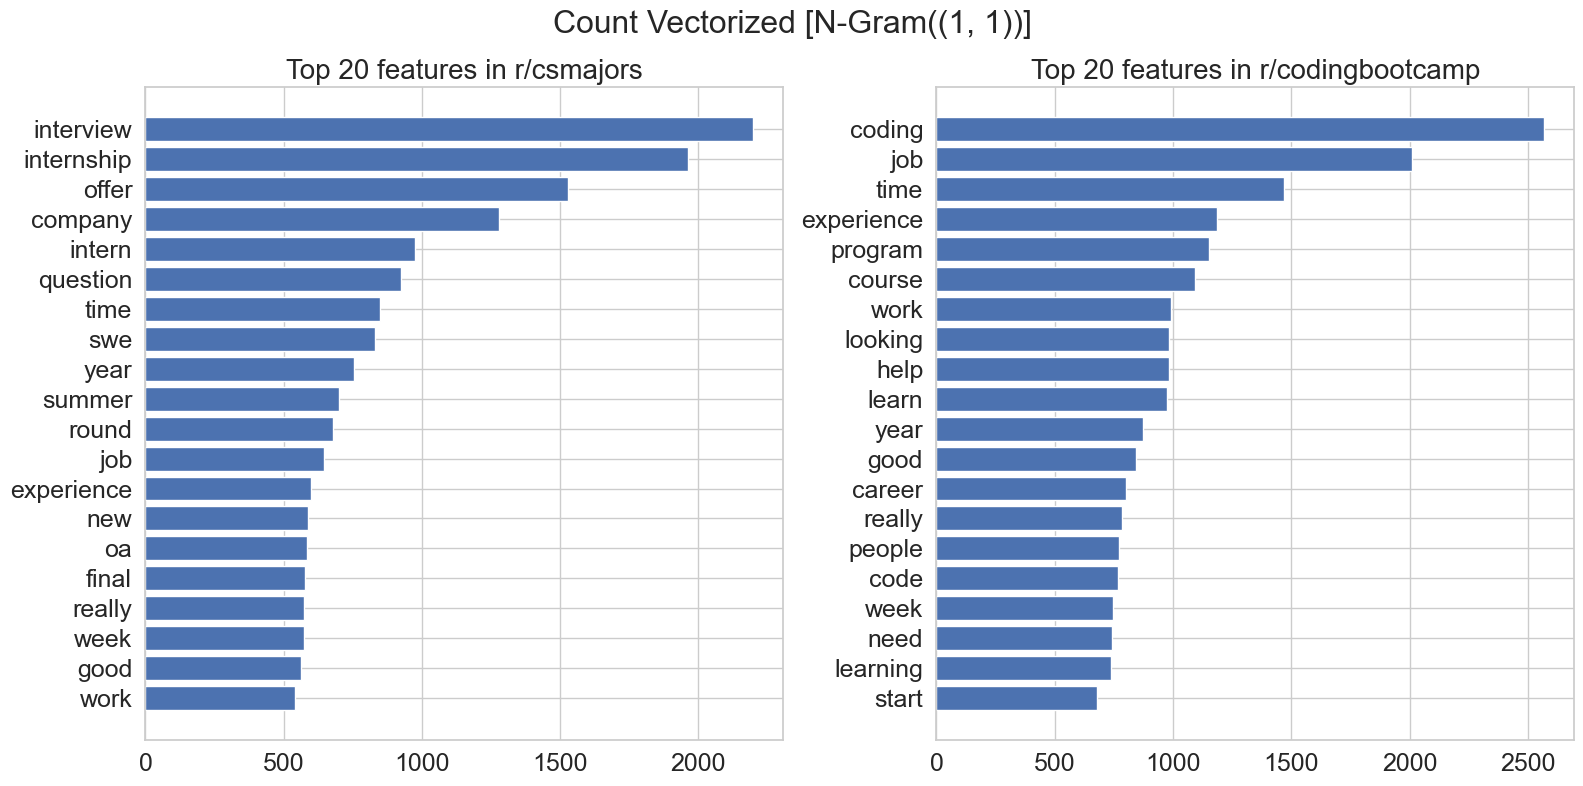

In [31]:
plot_top20()

From the unigram charts, we get a sense that r/csmajors seems to cater more towards graduates that are looking to land roles after graduation. We see unique terms like `swe` (software engineer) and `oa` (online assessment) that appear.

On the other hand, in r/codingbootcamp, it suggests that this caters more towards career switchers that are looking for suggestions.

### Bigram

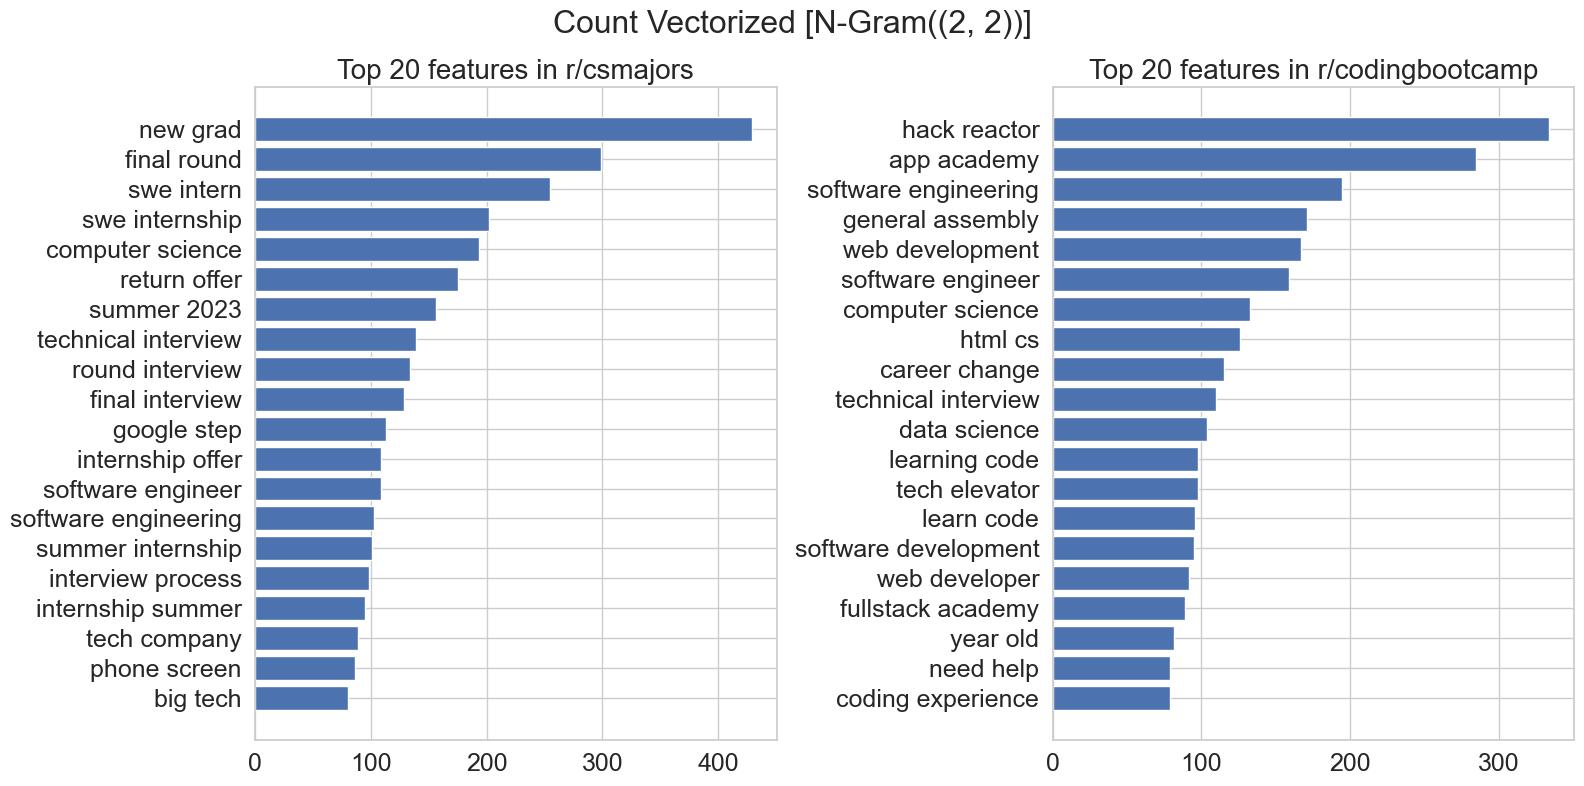

In [32]:
plot_top20((2,2))

The bigram charts further distinguish between the two subreddits. r/csmajors has more features relating to internships and interviews, while r/codingbootcamp talks more about skills. In fact, we see `career change` and `general assembly` appear within the top 20 words!

### Trigram

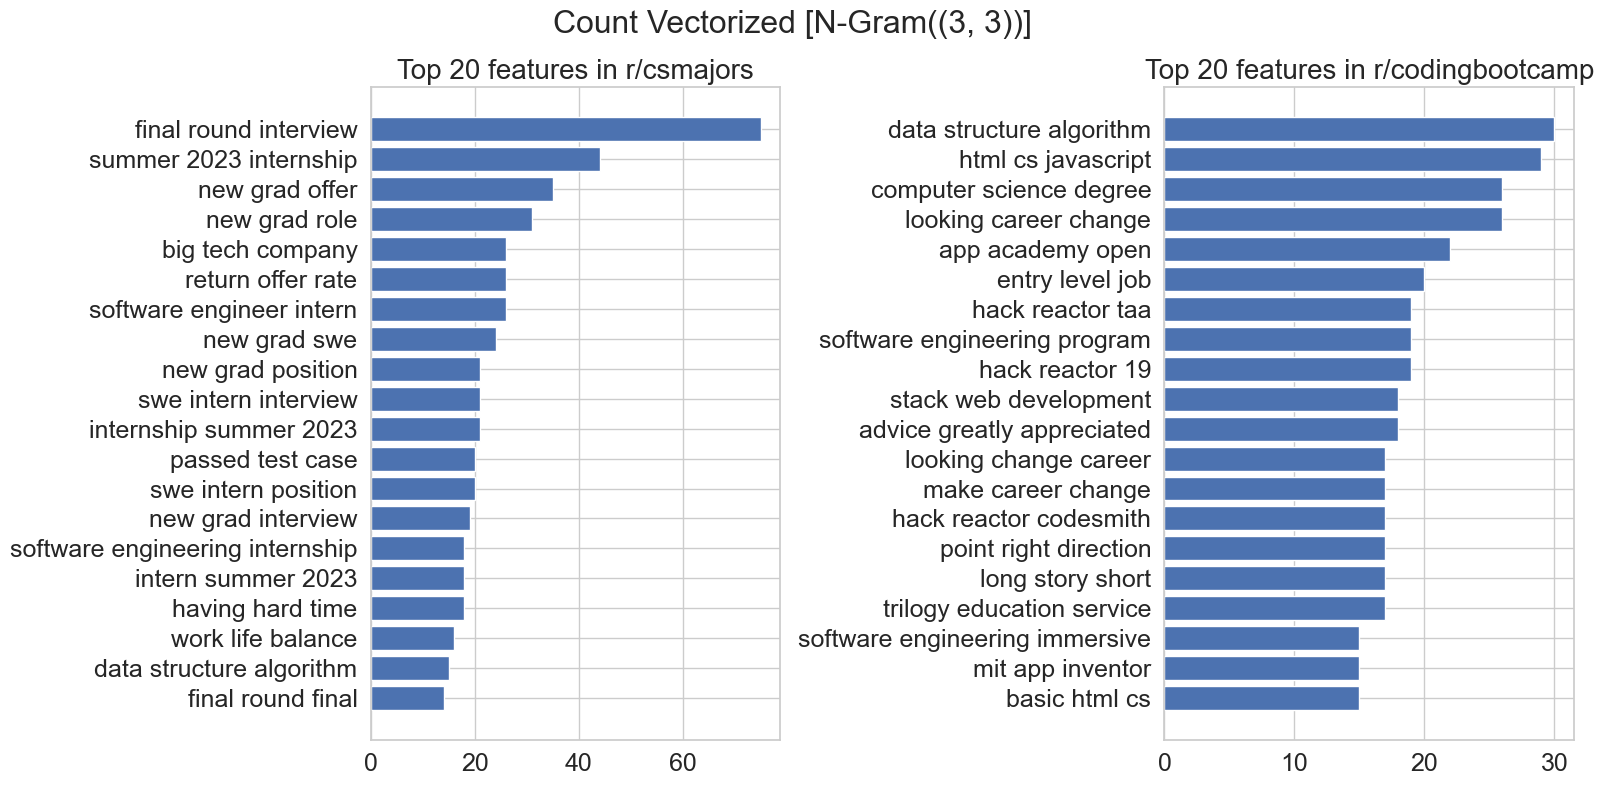

In [33]:
plot_top20((3,3))

Within the trigram charts, it is interesting to note that `work life balance` appears for r/csmajors, which could highlight one of the key trends in recent years, especially with the Gen Zs that are still in school.

For r/codingbootcamp, we see more terms that are directly relating to career switching and seeking advice.

Interestingly, `having hard time` appears in both subreddits, although without more context, it's hard to identify whether they are relating to the same challenges.

# Modelling
---
As we are trying to classify reddit posts into either of two subreddits, we will be using classifier models from the sklearn library. Each classifier will be run twice, once with each vectorizer.

We will try the following models, with Logistic Regression as our baseline for comparison:

- Logistic Regression (Baseline)
- Naive Bayes
    - Multinomial Naive Bayes
- Decision Tree
    - Random Forest Classifier 
    - Gradient Boosting Classifier
- Support Vector Model
    - Linear Support Vector Model Classifier

Naive Bayes models work on the basis of the [Bayes' theorem](https://en.wikipedia.org/wiki/Bayes%27_theorem), which describes the possibility of an event based on prior knowledge of conditions that might be related to our event. We expect that the Naive Bayes model 

As we are interested in maximising the number of True Positives for r/codingbootcamp while minimising the number of False Positives, we will be using the `something` metric to evaluate our models.

#### Insert something here about the metric.

In [34]:
# convert subreddit tags to numerical labels
df['label'] = df['subreddit'].str.lower().map({subreddits[0]: 0, subreddits[1]: 1})

In [35]:
# prepare X and y arrays for modelling
X = df['text_cleaned']
y = df['label']

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.7, random_state=42, stratify=y)

In [36]:
# prepare vectorizers and classifiers
count_vect = CountVectorizer(analyzer='word')
tfidf_vect = TfidfVectorizer(analyzer='word')

lr = LogisticRegression(solver='liblinear', max_iter=500, n_jobs=-1)

MultiNB = MultinomialNB()

rf = RandomForestClassifier(n_jobs=-1)
gbc = GradientBoostingClassifier(n_estimators=100)

svc = LinearSVC()

In [52]:
# create lists to store the model output results
model_list = []
mean_train_score = []
mean_test_score = []

In [53]:
def run_pipe(vector, clf, pipe_params):
    print(f"Fitting {vector} - {clf}")
    model_name = "-".join(re.findall(r'[\s\[](\w+)\(', str([vector, clf])))

    # create pipe
    pipe = Pipeline([
        ('vector', vector),
        ('clf', clf)
    ])
    
    # create GridSearchCV
    grid = GridSearchCV(
        estimator = pipe,
        param_grid = pipe_params,
        scoring = 'f1',
        n_jobs = -1,
        cv = 3,
        verbose = 1
    )

    grid.fit(X_train, y_train)
    
    train_score = cross_val_score(grid.best_estimator_, X_train, y_train, scoring='f1', cv=5, n_jobs=-1)
    test_score = cross_val_score(grid.best_estimator_, X_test, y_test, scoring='f1', cv=5, n_jobs=-1)
    # store average scores
    model_list.append(model_name)
    mean_train_score.append(train_score.mean())
    mean_test_score.append(test_score.mean())

    print("Best Score: ", grid.best_score_)
    print("Best Params: ", grid.best_params_)
    print()

    return grid.best_estimator_

In [54]:
# define vectorizer parameters for GridSearchCV
vector_params = {
    'vector__max_df': np.linspace(0.2, 1.0, 5),
    'vector__min_df': [1, 5],
    'vector__ngram_range': [(1,1), (1,2), (1,3)],
    'vector__max_features': [None, 5000, 50_000],
}

In [56]:
# define classifier parameters for GridSearchCV
lr_params = {
    'clf__penalty': ['l2', 'l1'],
}

MultiNB_params = {
    'clf__alpha': [0, 0.5, 1, 2],
}

rf_params = {
    'clf__max_leaf_nodes': [None, 10],
    'clf__class_weight': [None, 'balanced']
}

gbc_params = {
    'clf__max_depth': [3, 5, 10]
}

svc_params = {
    'clf__penalty': ['l2', 'l1'],
}

In [57]:
cv_lr = run_pipe(count_vect, lr, vector_params | lr_params)

tf_lr = run_pipe(tfidf_vect, lr, vector_params | lr_params)

Fitting CountVectorizer() - LogisticRegression(max_iter=500, n_jobs=-1, solver='liblinear')
Fitting 3 folds for each of 180 candidates, totalling 540 fits
Best Score:  0.9092446204315935
Best Params:  {'clf__penalty': 'l2', 'vector__max_df': 0.4, 'vector__max_features': None, 'vector__min_df': 1, 'vector__ngram_range': (1, 2)}

Fitting TfidfVectorizer() - LogisticRegression(max_iter=500, n_jobs=-1, solver='liblinear')
Fitting 3 folds for each of 180 candidates, totalling 540 fits
Best Score:  0.9117148466169879
Best Params:  {'clf__penalty': 'l2', 'vector__max_df': 0.4, 'vector__max_features': None, 'vector__min_df': 5, 'vector__ngram_range': (1, 3)}



In [58]:
cv_mnb = run_pipe(count_vect, MultiNB, vector_params | MultiNB_params)

tf_mnb = run_pipe(tfidf_vect, MultiNB, vector_params | MultiNB_params)

Fitting CountVectorizer() - MultinomialNB()
Fitting 3 folds for each of 360 candidates, totalling 1080 fits
Best Score:  0.9116856837647879
Best Params:  {'clf__alpha': 0.5, 'vector__max_df': 0.4, 'vector__max_features': None, 'vector__min_df': 1, 'vector__ngram_range': (1, 3)}

Fitting TfidfVectorizer() - MultinomialNB()
Fitting 3 folds for each of 360 candidates, totalling 1080 fits
Best Score:  0.9080379645348474
Best Params:  {'clf__alpha': 0.5, 'vector__max_df': 0.4, 'vector__max_features': None, 'vector__min_df': 1, 'vector__ngram_range': (1, 3)}



In [64]:
cv_rf = run_pipe(count_vect, rf, vector_params | rf_params)

tf_rf = run_pipe(tfidf_vect, rf, vector_params | rf_params)

Fitting CountVectorizer() - RandomForestClassifier(n_jobs=-1)
Fitting 3 folds for each of 360 candidates, totalling 1080 fits
Best Score:  0.9002166082294716
Best Params:  {'clf__class_weight': 'balanced', 'clf__max_leaf_nodes': None, 'vector__max_df': 0.6000000000000001, 'vector__max_features': 50000, 'vector__min_df': 1, 'vector__ngram_range': (1, 3)}

Fitting TfidfVectorizer() - RandomForestClassifier(n_jobs=-1)
Fitting 3 folds for each of 360 candidates, totalling 1080 fits
Best Score:  0.9007987085618759
Best Params:  {'clf__class_weight': 'balanced', 'clf__max_leaf_nodes': None, 'vector__max_df': 0.4, 'vector__max_features': 50000, 'vector__min_df': 1, 'vector__ngram_range': (1, 2)}



In [65]:
cv_gbc = run_pipe(count_vect, gbc, vector_params | gbc_params)

tf_gbc = run_pipe(tfidf_vect, gbc, vector_params | gbc_params)

Fitting CountVectorizer() - GradientBoostingClassifier()
Fitting 3 folds for each of 270 candidates, totalling 810 fits
Best Score:  0.8955709621298354
Best Params:  {'clf__max_depth': 10, 'vector__max_df': 1.0, 'vector__max_features': None, 'vector__min_df': 5, 'vector__ngram_range': (1, 3)}

Fitting TfidfVectorizer() - GradientBoostingClassifier()
Fitting 3 folds for each of 270 candidates, totalling 810 fits
Best Score:  0.8904271133619363
Best Params:  {'clf__max_depth': 5, 'vector__max_df': 0.6000000000000001, 'vector__max_features': 50000, 'vector__min_df': 1, 'vector__ngram_range': (1, 3)}



In [66]:
cv_svc = run_pipe(count_vect, svc, vector_params | svc_params)

tf_svc = run_pipe(tfidf_vect, svc, vector_params | svc_params)

Fitting CountVectorizer() - LinearSVC()
Fitting 3 folds for each of 180 candidates, totalling 540 fits
Best Score:  0.9008483379539
Best Params:  {'clf__penalty': 'l2', 'vector__max_df': 0.4, 'vector__max_features': None, 'vector__min_df': 1, 'vector__ngram_range': (1, 2)}

Fitting TfidfVectorizer() - LinearSVC()
Fitting 3 folds for each of 180 candidates, totalling 540 fits
Best Score:  0.917457015949851
Best Params:  {'clf__penalty': 'l2', 'vector__max_df': 0.4, 'vector__max_features': None, 'vector__min_df': 1, 'vector__ngram_range': (1, 2)}



In [67]:
# # iterate through the list of vectors and classifiers to compare performance
# vectors = [count_vect, tfidf_vect]
# clfs = [lr, MultiNB, CompNB, rf, gbc, svc]

# model_list = []
# mean_train_score = []
# mean_test_score = []

# # plt.figure(figsize=(8,8))
# # ax = plt.subplot()

# for vector in vectors:
#     for clf in clfs:
#         # extract and store model combination
#         model_name = "-".join(re.findall(r'[\s\[](\w+)\(', str([vector, clf])))
#         model_list.append(model_name)

#         pipe = Pipeline([
#             ('vector', vector),
#             ('clf', clf)
#         ])
#         print(f"Fitting {vector} - {clf}")
#         pipe.fit(X_train, y_train)
#         train_score = cross_val_score(pipe, X_train, y_train, scoring='f1', cv=5, n_jobs=-1)
#         test_score = cross_val_score(pipe, X_test, y_test, scoring='f1', cv=5, n_jobs=-1)
#         # store average scores
#         mean_train_score.append(train_score.mean())
#         mean_test_score.append(test_score.mean())

#         # roc_disp = PrecisionRecallDisplay.from_estimator(pipe, X_train, y_train, ax=ax, name=model_name)

# print("Completed")

# # plt.plot([0, 1], [0, 1], label='baseline', linestyle='--')
# # plt.title("ROC Curve Comparison across Models")
# # plt.legend();

In [102]:
# generate a dataframe to display results
model_dict = {
    'Mean Train F1-Score': mean_train_score,
    'Mean Test F1-Score': mean_test_score
    }

model_performance = pd.DataFrame(model_dict, index=model_list)
model_performance['Difference'] = abs(model_performance['Mean Train F1-Score'] - model_performance['Mean Test F1-Score'])

model_performance.sort_values(by="Mean Test F1-Score", ascending=False)

,Mean Train F1-Score,Mean Test F1-Score,Difference
TfidfVectorizer-LinearSVC,0.919045,0.914620,0.004425
CountVectorizer-MultinomialNB,0.911058,0.914450,0.003392
TfidfVectorizer-MultinomialNB,0.908062,0.909441,0.001380
CountVectorizer-LogisticRegression,0.910626,0.907409,0.003216
TfidfVectorizer-LogisticRegression,0.913550,0.907131,0.006419
CountVectorizer-LinearSVC,0.900162,0.901200,0.001038
TfidfVectorizer-RandomForestClassifier,0.899127,0.896631,0.002496
CountVectorizer-RandomForestClassifier,0.898910,0.894130,0.004780
CountVectorizer-GradientBoostingClassifier,0.895167,0.892720,0.002447
TfidfVectorizer-GradientBoostingClassifier,0.887675,0.888929,0.001254


## Model Evaluation and Tuning
Comparing the scores from the various models, the combination of `TF-IDF Vectorizer` and `Linear Support Vector Classification` appears to have the best performance with `0.919` mean train F1-score and `0.915` mean test F1-score. The `Count Vectorizer` and `Multinomial Naive Bayes` model has very similar performance, with `0.911` and `0.914` for the mean train and test F1-scores respectively.

We see that the difference between the train and test scores for all our models are generally less than 0.01, which suggests that our models are neither over-fitted or under-fitted and should have high generalisability with unseen data.

As we are interested to identify keywords that would be helpful to our GA Marketing team, we will opt to use the `Multinomial Naive Bayes` model so that we can identify the features that contribute to a positive classification. We will attempt to tune the hyper parameters of our model using `GridSearchCV` to achieve a higher performance.

In [98]:
# setting up GridSearch hyper parameters for tuning, tried features in comments
grid_params = {
    'vector__max_df': np.linspace(0.2, 1.0, 5),
    'vector__min_df': [1, 5],
    'vector__ngram_range': [(1,1), (1,2), (1,3)],
    'vector__max_features': [None, 5000, 50_000],
    'clf__alpha': [0, 0.1, 0.25, 0.5, 1],
    'clf__fit_prior': [True, False]
}

In [99]:
# utilising GridSearchCV to perform hyperparameter tuning with our best performing model
grid = GridSearchCV(
    estimator = cv_mnb,
    param_grid = grid_params,
    scoring = 'f1',
    n_jobs = -1,
    cv = 3,
    # return_train_score = True,
    verbose = 1
)

In [100]:
grid.fit(X_train, y_train)

Fitting 3 folds for each of 900 candidates, totalling 2700 fits


GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('vector',
                                        CountVectorizer(max_df=0.4,
                                                        ngram_range=(1, 3))),
                                       ('clf', MultinomialNB(alpha=0.5))]),
             n_jobs=-1,
             param_grid={'clf__alpha': [0, 0.1, 0.25, 0.5, 1],
                         'clf__fit_prior': [True, False],
                         'vector__max_df': array([0.2, 0.4, 0.6, 0.8, 1. ]),
                         'vector__max_features': [None, 5000, 50000],
                         'vector__min_df': [1, 5],
                         'vector__ngram_range': [(1, 1), (1, 2), (1, 3)]},
             scoring='f1', verbose=1)

In [103]:
print("Best Score: ", grid.best_score_)
print("Best Params: ", grid.best_params_)

Best Score:  0.9119076073759755
Best Params:  {'clf__alpha': 0.1, 'clf__fit_prior': True, 'vector__max_df': 0.4, 'vector__max_features': None, 'vector__min_df': 1, 'vector__ngram_range': (1, 2)}


In [104]:
# check performance of final model
cross_val_score(grid.best_estimator_, X_test, y_test, scoring='f1', cv=5).mean()

0.9104753721866368

After tuning, we see that the model is able to perform with around 90% F1-score on both train and test data.

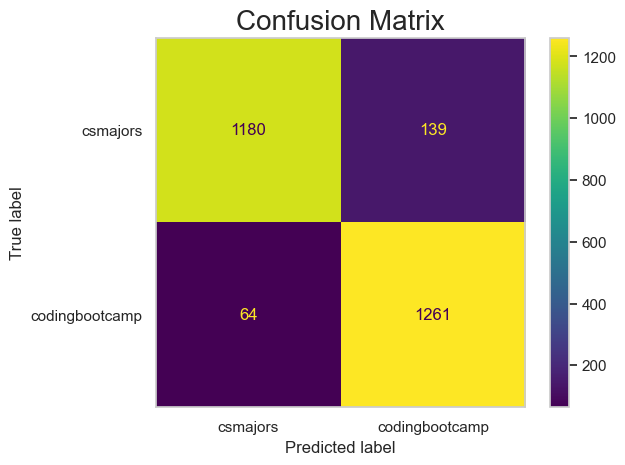

In [105]:
preds = grid.predict(X_test)
cm = confusion_matrix(y_test, preds)

cm_disp = ConfusionMatrixDisplay(cm, display_labels=subreddits)
cm_disp.plot()
plt.title("Confusion Matrix", fontsize=20)
plt.grid(None);

In [106]:
print(classification_report(y_test, preds,target_names=subreddits))

                precision    recall  f1-score   support

      csmajors       0.95      0.89      0.92      1319
codingbootcamp       0.90      0.95      0.93      1325

      accuracy                           0.92      2644
     macro avg       0.92      0.92      0.92      2644
  weighted avg       0.92      0.92      0.92      2644



From the classification report, we can see that our model is able to perform very well with around ~95% F1 score for both categories. The F1 score is a weighted average of both precision and recall, indicating the ability of our trained model to accurately classify a post.

![metrics](../images/metrics.png)

# Conclusion & Recommendations
---
Blah blah

Check the top performing words

In [129]:
def get_top_N_features(pipe, N=10):
    """
    Returns a bar plot with the token name and its feature importance to class 1
    relative to class 0 in terms of log-probabilities 
    (positive: contributes positively to the prediction for class 1).
    """
    check_array = pipe[1].feature_log_prob_[1, :] - pipe[1].feature_log_prob_[0, :]
    check_labels = pipe[0].get_feature_names_out()
    check_df = pd.DataFrame(check_array, index=check_labels)
    top_features = check_df.sort_values(by=0, ascending=False).head(N)

    # plot figure
    colors = ["r" if val < 0 else "b" for val in top_features[0]]
    plt.figure(figsize=(6,8))
    plt.barh(y=top_features.index, width=top_features[0], color=colors)
    plt.title(f"Top {N} Features" + "\n" + f"(Positive: Contributes to r/{subreddits[1]})", fontsize=20)

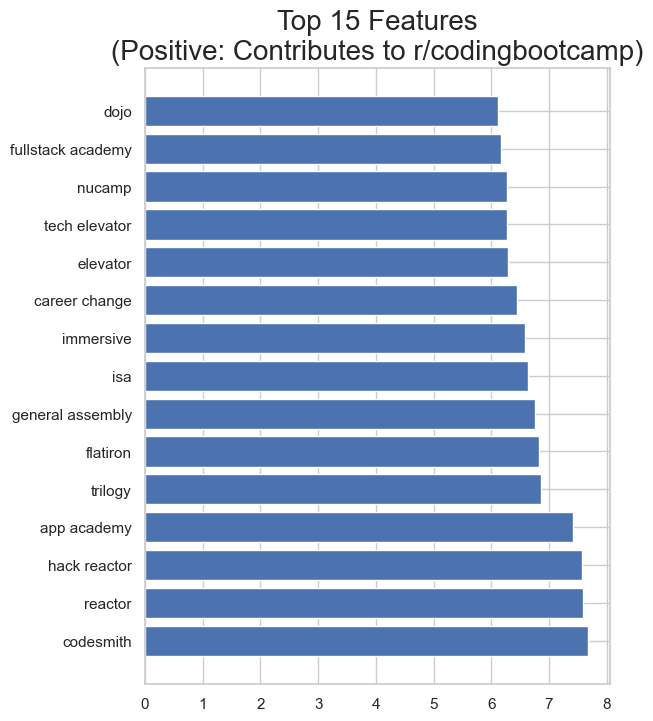

In [130]:
get_top_N_features(grid.best_estimator_, 15)

## Recommendations

## Live Prediction Model
As a proof of concept, we can launch a simple demonstration using `Flask`. We will save the trained model as a .pkl file for use with our web application.

Users can type or paste a length of text and the app will analyze the text to predict which subreddit the content might belong to.

In [114]:
# # check for app folder to store saved model
if not os.path.isdir('../app'):
    os.mkdir('../app')

joblib.dump(grid.best_estimator_, '../app/subreddit_model.pkl')

['../app/subreddit_model.pkl']

# References

1. [Develop a NLP Model in Python & Deploy It with Flask, Step by Step](https://towardsdatascience.com/develop-a-nlp-model-in-python-deploy-it-with-flask-step-by-step-744f3bdd7776)
1. [Pushshift API](https://github.com/pushshift/api/)
1. [F1 Score vs ROC AUC vs Accuracy vs PR AUC: Which Evaluation Metric Should You Choose?](https://neptune.ai/blog/f1-score-accuracy-roc-auc-pr-auc)
1. [Regional distribution of desktop traffic to Reddit.com as of May 2022 by country](https://www.statista.com/statistics/325144/reddit-global-active-user-distribution/)